# Overview

This Notebook contains the stock price prediction for the Apple Technology Company with the help of the past 2 years data.
XGBoost Machine learning Algorithm has been applied in the below model.<br>
<h2>Various steps involved in the process are -</h2><br>
1.Data Collection,cleaning and manipulating the data.<br>
2.Feature Engineering<br>
3.Training <br>
4.Hyperparameter Tuning<br>
5.Result Analysis<br>
IMPORTANT-Refernece has been taken through various github repo and this model was not build from scratch

In [1]:
#Import libraries required for the model
import numpy as np
import pandas as pd
import seaborn as sns
import time
import math
import matplotlib 
%inline matplotlib

UsageError: Line magic function `%inline` not found.


In [2]:
from datetime import date
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor

In [3]:
#Read the dataset 
df=pd.read_csv("AAPL (2).csv")

In [4]:
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-04-12,141.600006,142.149994,141.009995,141.800003,135.721542,20350000
1,2017-04-13,141.910004,142.380005,141.050003,141.050003,135.003723,17822900
2,2017-04-17,141.479996,141.880005,140.869995,141.830002,135.750275,16582100
3,2017-04-18,141.410004,142.039993,141.110001,141.199997,135.147308,14697500
4,2017-04-19,141.880005,142.000000,140.449997,140.679993,134.649567,17328400


In [5]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [6]:
#converting the Date column datatype into datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

In [7]:
df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [8]:
df.columns = [str(x).lower() for x in df.columns]

In [9]:
df.columns=[str(x).replace(' ', '_') for x in df.columns]

In [10]:
df.head()

,date,open,high,low,close,adj_close,volume
0,2017-04-12,141.600006,142.149994,141.009995,141.800003,135.721542,20350000
1,2017-04-13,141.910004,142.380005,141.050003,141.050003,135.003723,17822900
2,2017-04-17,141.479996,141.880005,140.869995,141.830002,135.750275,16582100
3,2017-04-18,141.410004,142.039993,141.110001,141.199997,135.147308,14697500
4,2017-04-19,141.880005,142.000000,140.449997,140.679993,134.649567,17328400


In [11]:
df['month'] = df['date'].dt.month

In [12]:
df.sort_values(by='date', inplace=True, ascending=True)

Text(0, 0.5, 'Price')

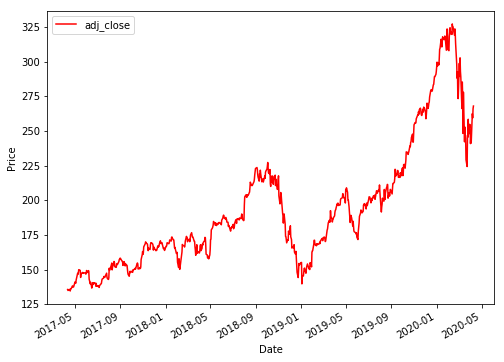

In [26]:
rcParams['figure.figsize'] = 8,6 
ax = df.plot(x='date', y='adj_close', style='r-')
ax.set_xlabel("Date")
ax.set_ylabel("Price")

# Feature Engineering

1.Mean volume of the month <br>
2.Mean adj_vol" of the month<br>
3.column with high - low value<br>
4.Column with Close - Open value <br>

In [22]:
# create a column with difference of high and the low value
df['diff_hi_lo'] = df['high'] - df['low']

In [23]:
df.drop(['high', 'low'], axis=1, inplace=True)

In [24]:
df.head()

,date,open,close,adj_close,volume,month,diff_hi_lo
0,2017-04-12,141.600006,141.800003,135.721542,20350000,4,1.139999
1,2017-04-13,141.910004,141.050003,135.003723,17822900,4,1.330002
2,2017-04-17,141.479996,141.830002,135.750275,16582100,4,1.010010
3,2017-04-18,141.410004,141.199997,135.147308,14697500,4,0.929992
4,2017-04-19,141.880005,140.679993,134.649567,17328400,4,1.550003


In [25]:
# create a column with difference of open and the close value
df['diff_op_cl'] = df['open'] - df['close']
df.drop(['open', 'close'], axis=1, inplace=True)

df.head()

,date,adj_close,volume,month,diff_hi_lo,diff_op_cl
0,2017-04-12,135.721542,20350000,4,1.139999,-0.199997
1,2017-04-13,135.003723,17822900,4,1.330002,0.860001
2,2017-04-17,135.750275,16582100,4,1.010010,-0.350006
3,2017-04-18,135.147308,14697500,4,0.929992,0.210007
4,2017-04-19,134.649567,17328400,4,1.550003,1.200012


In [27]:
df['order_day'] = [x for x in list(range(len(df)))]

In [28]:
# List of columns that we will use to create lags
lag_cols = ['adj_close', 'diff_hi_lo', 'diff_op_cl', 'volume']
lag_cols

['adj_close', 'diff_hi_lo', 'diff_op_cl', 'volume']

In [32]:
#adding columns as per the lag valuess
N=3
rang=[x+1 for x in range(N)]
merging_keys = ['order_day']
for val in tqdm_notebook(rang):
    train_shift = df[merging_keys + lag_cols].copy()
    train_shift['order_day'] = train_shift['order_day'] + val
    foo = lambda x: '{}_lag_{}'.format(x, val) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
del train_shift

# Remove the first N rows which contain NaNs
df = df[N:]
    
df.head()

,date,adj_close,volume,month,diff_hi_lo,diff_op_cl,order_day,adj_close_lag_1,diff_hi_lo_lag_1,diff_op_cl_lag_1,volume_lag_1,adj_close_lag_2,diff_hi_lo_lag_2,diff_op_cl_lag_2,volume_lag_2,adj_close_lag_3,diff_hi_lo_lag_3,diff_op_cl_lag_3,volume_lag_3
3,2017-04-18,135.147308,14697500,4,0.929992,0.210007,3,135.750275,1.010010,-0.350006,16582100.0,135.003723,1.330002,0.860001,17822900.0,135.721542,1.139999,-0.199997,20350000.0
4,2017-04-19,134.649567,17328400,4,1.550003,1.200012,4,135.147308,0.929992,0.210007,14697500.0,135.750275,1.010010,-0.350006,16582100.0,135.003723,1.330002,0.860001,17822900.0
5,2017-04-20,136.334137,23319600,4,1.759994,-1.220001,5,134.649567,1.550003,1.200012,17328400.0,135.147308,0.929992,0.210007,14697500.0,135.750275,1.010010,-0.350006,16582100.0
6,2017-04-21,136.171432,17320900,4,0.829987,0.169998,6,136.334137,1.759994,-1.220001,23319600.0,134.649567,1.550003,1.200012,17328400.0,135.147308,0.929992,0.210007,14697500.0
7,2017-04-24,137.482697,17134300,4,0.770004,-0.139999,7,136.171432,0.829987,0.169998,17320900.0,136.334137,1.759994,-1.220001,23319600.0,134.649567,1.550003,1.200012,17328400.0


In [33]:
def get_mov_avg_std(df, col, N):
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

In [34]:
cols_list = ["adj_close","diff_hi_lo","diff_op_cl","volume"]

for col in cols_list:
    df = get_mov_avg_std(df, col, N)
df.head()

,date,adj_close,volume,month,diff_hi_lo,diff_op_cl,order_day,adj_close_lag_1,diff_hi_lo_lag_1,diff_op_cl_lag_1,...,diff_op_cl_lag_3,volume_lag_3,adj_close_mean,adj_close_std,diff_hi_lo_mean,diff_hi_lo_std,diff_op_cl_mean,diff_op_cl_std,volume_mean,volume_std
3,2017-04-18,135.147308,14697500,4,0.929992,0.210007,3,135.750275,1.010010,-0.350006,...,-0.199997,20350000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-04-19,134.649567,17328400,4,1.550003,1.200012,4,135.147308,0.929992,0.210007,...,0.860001,17822900.0,135.147308,NaN,0.929992,NaN,0.210007,NaN,1.469750e+07,NaN
5,2017-04-20,136.334137,23319600,4,1.759994,-1.220001,5,134.649567,1.550003,1.200012,...,-0.350006,16582100.0,134.898438,0.351956,1.239997,0.438414,0.705010,0.700039,1.601295e+07,1.860327e+06
6,2017-04-21,136.171432,17320900,4,0.829987,0.169998,6,136.334137,1.759994,-1.220001,...,0.210007,14697500.0,135.377004,0.865456,1.413330,0.431550,0.063339,1.216655,1.844850e+07,4.418837e+06
7,2017-04-24,137.482697,17134300,4,0.770004,-0.139999,7,136.171432,0.829987,0.169998,...,1.200012,17328400.0,135.718379,0.929186,1.379995,0.487755,0.050003,1.214461,1.932297e+07,3.461188e+06


In [37]:
cv_size=0.2
test_size=0.2
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 451
num_cv = 150
num_test = 150
train.shape = (451, 27)
cv.shape = (150, 27)
train_cv.shape = (601, 27)
test.shape = (150, 27)


# Normalizing the data

In [39]:
cols_to_scale = ["adj_close"]

for i in range(1,N+1):
    cols_to_scale.append("adj_close_lag_"+str(i))
    cols_to_scale.append("diff_hi_lo_lag_"+str(i))
    cols_to_scale.append("diff_op_cl_lag_"+str(i))
    cols_to_scale.append("volume_lag_"+str(i))

# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))
print("train_scaled.shape = " + str(train_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
train_scaled[['date', 'month']] = train.reset_index()[['date', 'month']]
print("train_scaled.shape = " + str(train_scaled.shape))
train_scaled.head()

scaler.mean_ = [ 1.70015508e+02  1.69953784e+02  3.13591992e+00 -2.35034812e-03
  3.15843450e+07  1.69892997e+02  3.12574255e+00  3.99111752e-03
  3.14883652e+07  1.69856838e+02  3.11935673e+00  6.64966741e-05
  3.14412761e+07]
scaler.var_ = [5.39161039e+02 5.41668966e+02 3.53621539e+00 4.70517882e+00
 1.90541001e+14 5.44247809e+02 3.52615671e+00 4.69793915e+00
 1.89018762e+14 5.46128063e+02 3.53308594e+00 4.69257830e+00
 1.89065495e+14]
train_scaled.shape = (451, 13)
train_scaled.shape = (451, 15)


,adj_close,adj_close_lag_1,diff_hi_lo_lag_1,diff_op_cl_lag_1,volume_lag_1,adj_close_lag_2,diff_hi_lo_lag_2,diff_op_cl_lag_2,volume_lag_2,adj_close_lag_3,diff_hi_lo_lag_3,diff_op_cl_lag_3,volume_lag_3,date,month
0,-1.501655,-1.469615,-1.130513,-0.160273,-1.086831,-1.495525,-0.956297,0.394935,-0.993967,-1.460685,-1.053046,-0.092355,-0.806632,2017-04-18,4
1,-1.523091,-1.495523,-1.173065,0.097899,-1.223360,-1.463524,-1.126704,-0.163323,-1.084217,-1.491401,-0.951961,0.396972,-0.990420,2017-04-19,4
2,-1.450543,-1.516909,-0.843356,0.554303,-1.032766,-1.489370,-1.169317,0.095049,-1.221295,-1.459455,-1.122202,-0.161604,-1.080659,2017-04-20,4
3,-1.457550,-1.444529,-0.731688,-0.561351,-0.598736,-1.510706,-0.839138,0.551804,-1.029935,-1.485257,-1.164772,0.096915,-1.217720,2017-04-21,4
4,-1.401078,-1.451520,-1.226245,0.079455,-1.033309,-1.438497,-0.727311,-0.564709,-0.594161,-1.506555,-0.834918,0.553931,-1.026383,2017-04-24,4


In [40]:
# Do scaling for train+dev set
scaler_train_cv = StandardScaler()
train_cv_scaled = scaler_train_cv.fit_transform(train_cv[cols_to_scale])
print("scaler_train_cv.mean_ = " + str(scaler_train_cv.mean_))
print("scaler_train_cv.var_ = " + str(scaler_train_cv.var_))
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_cv_scaled = pd.DataFrame(train_cv_scaled, columns=cols_to_scale)
train_cv_scaled[['date', 'month']] = train_cv.reset_index()[['date', 'month']]
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))
train_cv_scaled.head()

scaler_train_cv.mean_ = [ 1.75402759e+02  1.75275658e+02  3.21740416e+00 -5.54576273e-02
  3.05554168e+07  1.75154084e+02  3.21602315e+00 -5.26955574e-02
  3.05531453e+07  1.75039479e+02  3.21332765e+00 -5.42429667e-02
  3.05536894e+07]
scaler_train_cv.var_ = [5.34943367e+02 5.35297982e+02 3.53005104e+00 4.59511218e+00
 1.71119929e+14 5.36192283e+02 3.53411595e+00 4.59557662e+00
 1.71174668e+14 5.37323808e+02 3.54093383e+00 4.59459102e+00
 1.71163387e+14]
train_cv_scaled.shape = (601, 13)
train_cv_scaled.shape = (601, 15)


,adj_close,adj_close_lag_1,diff_hi_lo_lag_1,diff_op_cl_lag_1,volume_lag_1,adj_close_lag_2,diff_hi_lo_lag_2,diff_op_cl_lag_2,volume_lag_2,adj_close_lag_3,diff_hi_lo_lag_3,diff_op_cl_lag_3,volume_lag_3,date,month
0,-1.740487,-1.708356,-1.174869,-0.137407,-1.068192,-1.733920,-1.003243,0.425752,-0.973009,-1.696183,-1.101816,-0.067998,-0.779923,2017-04-18,4
1,-1.762007,-1.734417,-1.217458,0.123839,-1.212260,-1.701680,-1.173458,-0.138688,-1.067847,-1.727150,-1.000844,0.426519,-0.973083,2017-04-19,4
2,-1.689173,-1.755930,-0.887462,0.585677,-1.011141,-1.727720,-1.216023,0.122545,-1.211893,-1.694943,-1.170896,-0.137981,-1.067924,2017-04-20,4
3,-1.696208,-1.683120,-0.775696,-0.543260,-0.553143,-1.749215,-0.886217,0.584359,-1.010805,-1.720955,-1.213419,0.123280,-1.211974,2017-04-21,4
4,-1.639514,-1.690153,-1.270685,0.105175,-1.011714,-1.676466,-0.774515,-0.544521,-0.552881,-1.742428,-0.883930,0.585144,-1.010880,2017-04-24,4


In [43]:
def scale_row(row, feat_mean, feat_std):
    # If feat_std = 0 (this happens if adj_close doesn't change over N days), 
    # set it to a small number to avoid division by zero
    feat_std = 0.001 if feat_std == 0 else feat_std
    row_scaled = (row-feat_mean) / feat_std 
    return row_scaled
# Do scaling for dev set
cv_scaled = cv[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = cv.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    cv_scaled = pd.concat([cv_scaled, temp], axis=1)
    
# Now the entire dev set is scaled
cv_scaled.head()

,date,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,diff_hi_lo_lag_1,diff_hi_lo_lag_2,diff_hi_lo_lag_3,diff_op_cl_lag_1,diff_op_cl_lag_2,diff_op_cl_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
454,2019-02-01,0.666818,0.482995,-1.149813,-0.354019,1.128851,-0.774832,-0.042922,-0.977848,1.020770,-0.613736,1.153919,-0.540184
455,2019-02-04,0.632685,0.520187,-1.152872,-0.989385,-0.020902,1.010287,0.857815,0.240507,-1.098322,-0.830374,-0.279694,1.110068
456,2019-02-05,1.154579,-0.562764,-0.591815,0.538752,-1.153859,0.615107,-1.138141,0.737820,0.400321,-0.689914,-0.456925,1.146839
457,2019-02-06,0.913305,0.155234,-1.068539,-0.750475,1.135231,-0.384756,0.117764,-1.053668,0.935904,1.119529,-0.804695,-0.314835
458,2019-02-07,0.594814,0.559709,-1.154523,-0.582572,-0.572112,1.154685,0.932681,0.123218,-1.055899,-0.938154,1.052087,-0.113933


In [46]:
features = []
for i in range(1,N+1):
    features.append("adj_close_lag_"+str(i))
    features.append("diff_hi_lo_lag_"+str(i))
    features.append("diff_op_cl_lag_"+str(i))
    features.append("volume_lag_"+str(i))

target = "adj_close"


# Split into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]

In [47]:
test_scaled = test[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    test_scaled = pd.concat([test_scaled, temp], axis=1)
    
# Now the entire test set is scaled
test_scaled.head()
# Split into X and y
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled[target]
X_cv_scaled = cv_scaled[features]
X_train_cv_scaled = train_cv_scaled[features]
y_train_cv_scaled = train_cv_scaled[target]
X_sample_scaled = test_scaled[features]
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
print("X_cv_scaled.shape = " + str(X_cv_scaled.shape))
print("X_train_cv_scaled.shape = " + str(X_train_cv_scaled.shape))
print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))
print("X_sample_scaled.shape = " + str(X_sample_scaled.shape))


X_train_scaled.shape = (451, 12)
y_train_scaled.shape = (451,)
X_cv_scaled.shape = (150, 12)
X_train_cv_scaled.shape = (601, 12)
y_train_cv_scaled.shape = (601,)
X_sample_scaled.shape = (150, 12)


In [48]:
# Split into X and y
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled[target]
X_cv_scaled = cv_scaled[features]
X_train_cv_scaled = train_cv_scaled[features]
y_train_cv_scaled = train_cv_scaled[target]
X_sample_scaled = test_scaled[features]
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
print("X_cv_scaled.shape = " + str(X_cv_scaled.shape))
print("X_train_cv_scaled.shape = " + str(X_train_cv_scaled.shape))
print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))
print("X_sample_scaled.shape = " + str(X_sample_scaled.shape))

X_train_scaled.shape = (451, 12)
y_train_scaled.shape = (451,)
X_cv_scaled.shape = (150, 12)
X_train_cv_scaled.shape = (601, 12)
y_train_cv_scaled.shape = (601,)
X_sample_scaled.shape = (150, 12)


# PLOT

Text(0.5, 1.0, 'Without scaling')

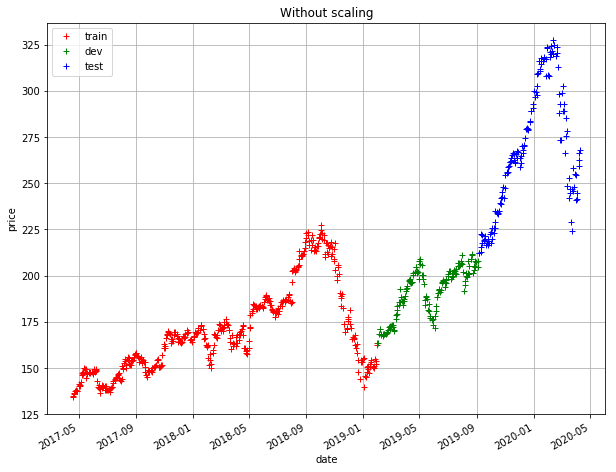

In [50]:
rcParams['figure.figsize'] = 10,8

ax = train.plot(x='date', y='adj_close', style='r+', grid=True)
ax = cv.plot(x='date', y='adj_close', style='g+', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='b+', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("price")
ax.set_title("Without scaling")

Text(0.5, 1.0, 'With scaling')

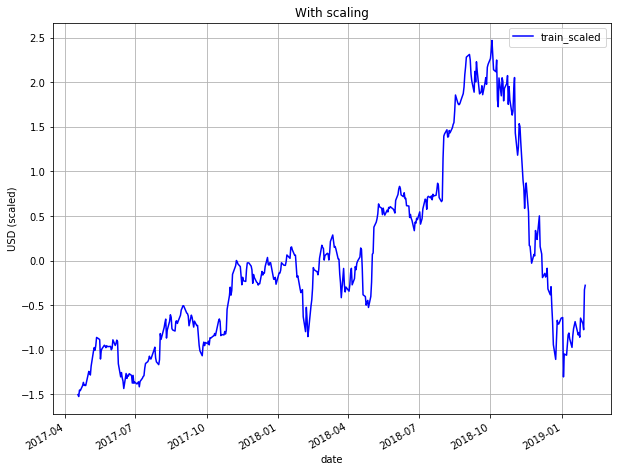

In [51]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train_scaled.plot(x='date', y='adj_close', style='b-', grid=True)
ax.legend(['train_scaled'])
ax.set_xlabel("date")
ax.set_ylabel("USD (scaled)")
ax.set_title("With scaling")

# Model Training

In [53]:
#default values
n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14
# Create the model
model = XGBRegressor(seed=model_seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel,
                     gamma=gamma)

# Train the regressor
model.fit(X_train_scaled, y_train_scaled)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=100, n_jobs=0, num_parallel_tree=1,
       objective='reg:squarederror', random_state=100, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=100, subsample=1,
       tree_method=None, validate_parameters=False, verbosity=None)

In [60]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed=100, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0):
        model = XGBRegressor(seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
        model.fit(X_train_scaled,y_train_scaled)    
        # Get predicted labels and scale back to original range
        est_scaled = model.predict(X_test_scaled)
        est = est_scaled * col_std + col_mean

        # Calculate RMSE
        rmse = math.sqrt(mean_squared_error(y_test, est))
        mape = get_mape(y_test, est)
    
        return rmse, mape, est

# Prediction

In [61]:
# Do prediction on train set
est_scaled = model.predict(X_train_scaled)
est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

# Calculate RMSE
print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))

# Calculate MAPE
print("MAPE on train set = %0.3f%%" % get_mape(y_train, est))

RMSE on train set = 1.528
MAPE on train set = 0.665%


Text(0.5, 1.0, 'Without scaling')

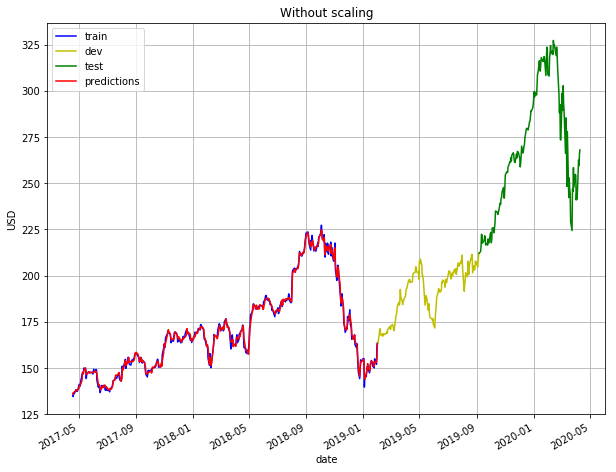

In [62]:
rcParams['figure.figsize'] = 10, 8

est_df = pd.DataFrame({'est': est, 
                       'date': train['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title('Without scaling')

In [63]:
# Do prediction on test set
est_scaled = model.predict(X_cv_scaled)
cv['est_scaled'] = est_scaled
cv['est'] = cv['est_scaled'] * cv['adj_close_std'] + cv['adj_close_mean']

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, cv['est']))
print("RMSE on dev set = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_bef_tuning = get_mape(y_cv, cv['est'])
print("MAPE on dev set = %0.3f%%" % mape_bef_tuning)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


RMSE on dev set = 3.079
MAPE on dev set = 1.161%


# Hyperparameter Tuning

In [101]:
param_label = 'n_estimators'
param_list = range(10, 250, 15)

param2_label = 'max_depth'
param2_list = [2,3,4,5,6,8,9]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=param, 
                                     max_depth=param2, 
                                     learning_rate=learning_rate, 
                                     min_child_weight=min_child_weight, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate


Minutes taken = 0.2052468498547872


,n_estimators,max_depth,rmse,mape_pct
0,10,2,3.178880,1.202810
1,10,3,3.196388,1.210426
2,10,4,3.176880,1.197181
3,10,5,3.150189,1.180193
4,10,6,3.147510,1.179136
5,10,8,3.143095,1.176897
6,10,9,3.142630,1.176673
7,25,2,3.083496,1.165505
8,25,3,3.080272,1.157877
9,25,4,3.088697,1.167439


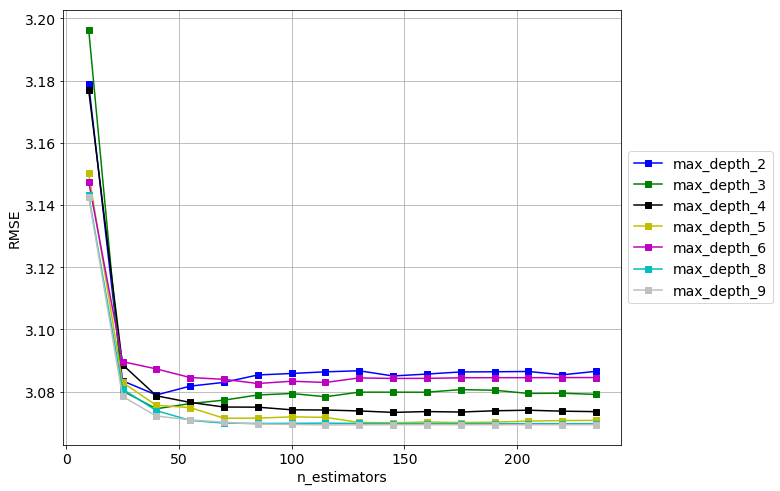

In [102]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [103]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

min RMSE = 3.069
optimum params = 


(115, 9)

In [104]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['n_estimators'].values[0], temp['max_depth'].values[0]

min MAPE = 1.156%
optimum params = 


(40, 3)

In [105]:
param_label = 'learning_rate'
param_list = [0.0001, 0.001, 0.01,0.1,0.2,0.3,0.5]

param2_label = 'min_child_weight'
param2_list = range(5, 21, 1)

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=param, 
                                     min_child_weight=param2, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate


Minutes taken = 0.21992533206939696


,learning_rate,min_child_weight,rmse,mape_pct
0,0.0001,5,3.783229,1.430036
1,0.0001,6,3.783193,1.429996
2,0.0001,7,3.783168,1.429993
3,0.0001,8,3.783248,1.430026
4,0.0001,9,3.783184,1.429999
5,0.0001,10,3.783185,1.429999
6,0.0001,11,3.783185,1.429999
7,0.0001,12,3.783185,1.429999
8,0.0001,13,3.783183,1.429997
9,0.0001,14,3.783166,1.430006


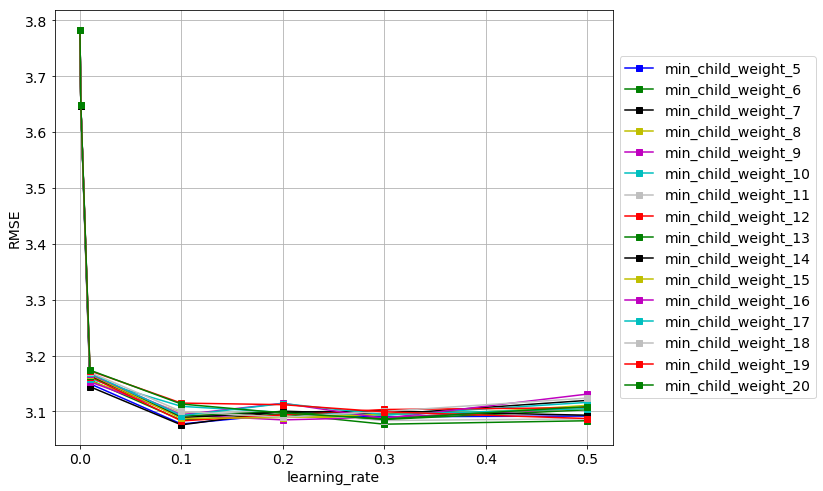

In [106]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside 

In [107]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
learning_rate_opt, min_child_weight_opt

min RMSE = 3.076
optimum params = 


(0.1, 7)

In [108]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['learning_rate'].values[0], temp['min_child_weight'].values[0]

min MAPE = 1.154%
optimum params = 


(0.3, 6)

In [109]:
param_label = 'subsample'
param_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

param2_label = 'gamma'
param2_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=param, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate



Minutes taken = 0.18105832735697427


,subsample,gamma,rmse,mape_pct
0,0.1,0.1,3.091007,1.160564
1,0.1,0.2,3.088351,1.162724
2,0.1,0.3,3.098643,1.159638
3,0.1,0.4,3.104101,1.168244
4,0.1,0.5,3.102005,1.167489
5,0.1,0.6,3.092230,1.163053
6,0.1,0.7,3.100436,1.167208
7,0.1,0.8,3.124116,1.178528
8,0.1,0.9,3.091568,1.161965
9,0.1,1.0,3.106472,1.167502


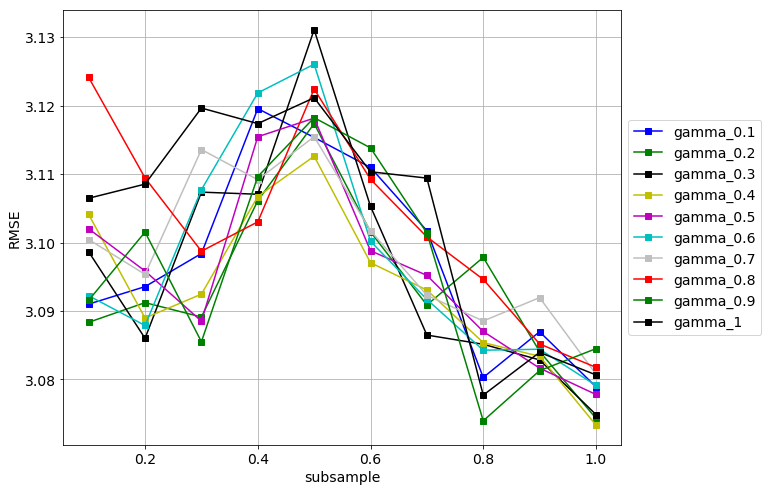

In [110]:
#Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [111]:

# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
subsample_opt, gamma_opt

min RMSE = 3.073
optimum params = 


(1.0, 0.4)

In [112]:
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['subsample'].values[0], temp['gamma'].values[0]

min MAPE = 1.160%
optimum params = 


(0.1, 0.3)

In [113]:
param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=subsample_opt, 
                                     colsample_bytree=param, 
                                     colsample_bylevel=param2, 
                                     gamma=gamma_opt)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate


Minutes taken = 0.08105765183766683


,colsample_bytree,colsample_bylevel,rmse,mape_pct
0,0.5,0.5,3.733754,1.491371
1,0.5,0.6,3.733754,1.491371
2,0.5,0.7,3.751712,1.497381
3,0.5,0.8,3.751712,1.497381
4,0.5,0.9,3.738579,1.492003
5,0.5,1.0,3.540990,1.399644
6,0.6,0.5,3.616125,1.438690
7,0.6,0.6,3.600073,1.426888
8,0.6,0.7,3.600073,1.426888
9,0.6,0.8,3.515321,1.391692


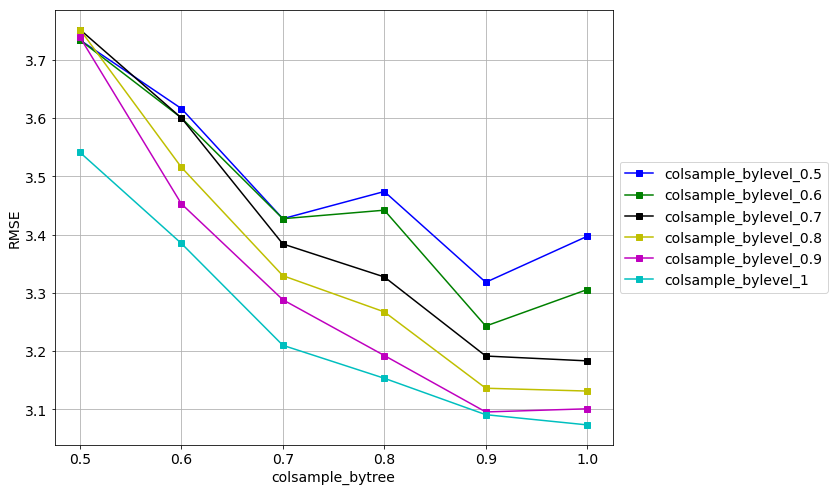

In [114]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [115]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
colsample_bytree_opt = temp['colsample_bytree'].values[0]
colsample_bylevel_opt = temp['colsample_bylevel'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
colsample_bytree_opt, colsample_bylevel_opt

min RMSE = 3.073
optimum params = 


(1.0, 1.0)

In [116]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['colsample_bytree'].values[0], temp['colsample_bylevel'].values[0]

min MAPE = 1.162%
optimum params = 


(1.0, 1.0)

# Tuned Parameters


In [117]:
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma', 'rmse', 'mape_pct'],
     'original': [n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma, rmse_bef_tuning, mape_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, colsample_bytree_opt, colsample_bylevel_opt, gamma_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params.round(3)
tuned_params

,param,original,after_tuning
0,n_estimators,100.000,115.000
1,max_depth,3.000,9.000
2,learning_rate,0.100,0.100
3,min_child_weight,1.000,7.000
4,subsample,1.000,1.000
5,colsample_bytree,1.000,1.000
6,colsample_bylevel,1.000,1.000
7,gamma,0.000,0.400
8,rmse,3.079,3.073
9,mape_pct,1.161,1.162
